<a href="https://colab.research.google.com/github/NoCodeProgram/deepLearning/blob/main/nn/multi_class_one_hot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/NoCodeProgram/deepLearning.git


Cloning into 'deepLearning'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 72 (delta 15), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (72/72), 2.29 MiB | 4.47 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [2]:
import torch
import pandas as pd

# Load the DataFrame from a CSV file
df = pd.read_csv('./deepLearning/nn/classify_3c_5k.csv')
print(df.head())
# Convert the DataFrame to a numpy array
data = df[['x', 'y']].values
labels = df['label'].values

# Print the shapes of the data and labels
print(f'Data shape: {data.shape}')
print(f'Labels shape: {labels.shape}')



          x         y  label
0  0.097627  0.430379      1
1  0.205527  0.089766      2
2 -0.152690  0.291788      1
3 -0.124826  0.783546      0
4  0.927326 -0.233117      0
Data shape: (5000, 2)
Labels shape: (5000,)


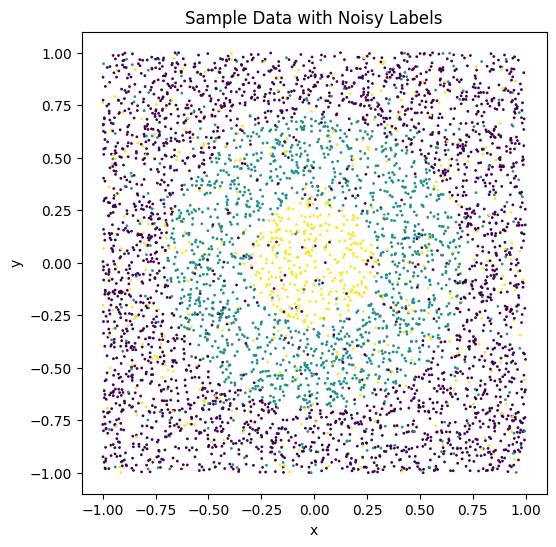

In [3]:
import matplotlib.pyplot as plt

# Plot the points
plt.figure(figsize=(6, 6))
plt.scatter(data[:,0], data[:,1], c=labels, cmap='viridis', s=1)
plt.title('Sample Data with Noisy Labels')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [6]:
import torch.nn.functional as F

data_torch = torch.tensor(data, dtype=torch.float32)
labels_torch = torch.tensor(labels)

print(f"before, one hot : {labels_torch.shape}")
labels_torch = F.one_hot(labels_torch)
print(f"after, one hot : {labels_torch.shape}")

data_length = len(data_torch)
split_length = int(0.8*data_length)

train_data = data_torch[:split_length]
train_labels = labels_torch[:split_length]
val_data = data_torch[split_length:]
val_labels = labels_torch[split_length:]

print(train_data.shape, train_labels.shape, train_labels.dtype)



before, one hot : torch.Size([5000])
after, one hot : torch.Size([5000, 3])
torch.Size([4000, 2]) torch.Size([4000, 3]) torch.int64


In [7]:
g = torch.Generator().manual_seed(42)

def get_batch(data, labels, batch_size=256):
    indices = torch.randint(0, len(data), size=(batch_size,), generator= g)

    data_batch = data[indices]
    labels_batch = labels[indices]

    return data_batch, labels_batch

data_batch, labels_batch = get_batch(train_data,train_labels)
print(data_batch.shape, labels_batch.shape)

torch.Size([256, 2]) torch.Size([256, 3])


In [8]:
def custom_cross_entropy_loss(output, ont_hot_label):
    exp_output = torch.exp(output)
    total = torch.sum(exp_output, dim=1, keepdim=True)
    softmax_output = exp_output/total
    log_prob = - torch.log(softmax_output)
    nll = (log_prob * ont_hot_label).sum(dim=1)
    return torch.mean(nll)



In [9]:
import torch
import torch.nn as nn
import torch.optim as optim


input_size = 2
hidden_size = 4
output_size = 3

torch.manual_seed(42)
g.manual_seed(42)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq_model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.seq_model(x)

net = Net()
optimizer = optim.SGD(net.parameters(), lr=0.01)

for steps in range(100000):
    net.train()
    data_batch, labels_batch = get_batch(data_torch, labels_torch, batch_size=256)
    output = net(data_batch)

    loss = custom_cross_entropy_loss(output, labels_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if steps % 1000 == 0:
        net.eval()
        output = net(val_data)
        val_loss = custom_cross_entropy_loss(output, val_labels)
        print(f"{steps} val_loss: {val_loss.item()}")


0 val_loss: 1.1056251525878906
1000 val_loss: 0.9670233726501465
2000 val_loss: 0.96729975938797
3000 val_loss: 0.9666537642478943
4000 val_loss: 0.9654695391654968
5000 val_loss: 0.96275794506073
6000 val_loss: 0.9593054056167603
7000 val_loss: 0.9535040855407715
8000 val_loss: 0.9438685774803162
9000 val_loss: 0.9269222021102905
10000 val_loss: 0.8950017690658569
11000 val_loss: 0.8204203248023987
12000 val_loss: 0.7642731666564941
13000 val_loss: 0.7433012127876282
14000 val_loss: 0.7342105507850647
15000 val_loss: 0.7313199043273926
16000 val_loss: 0.7296494245529175
17000 val_loss: 0.7274362444877625
18000 val_loss: 0.7254444360733032
19000 val_loss: 0.7245737910270691
20000 val_loss: 0.7209059000015259
21000 val_loss: 0.718664288520813
22000 val_loss: 0.7181721329689026
23000 val_loss: 0.7145180702209473
24000 val_loss: 0.7124754786491394
25000 val_loss: 0.7089722752571106
26000 val_loss: 0.7018445730209351
27000 val_loss: 0.6972601413726807
28000 val_loss: 0.6905602812767029
290

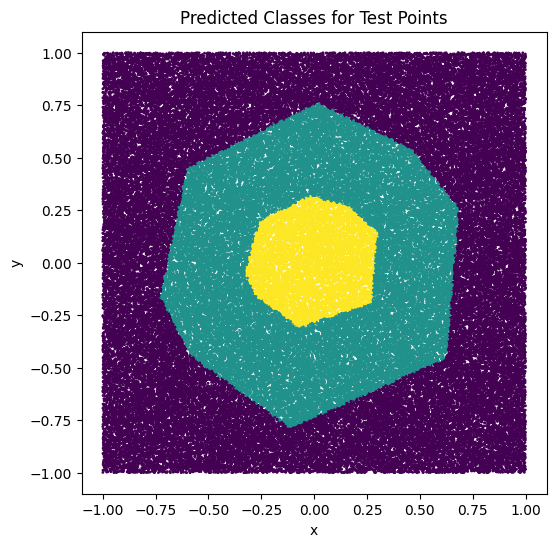

In [11]:
import numpy as np
import matplotlib.pyplot as plt

n_points_test = 100000
points_test = np.random.uniform(-1, 1, (n_points_test, 2))
points_test_torch = torch.from_numpy(points_test).float()

net.eval()
output_test = net(points_test_torch)

probabilities = torch.softmax(output_test, dim=1)
predictions = torch.argmax(probabilities, dim=1)
predictions_np = predictions.numpy()

plt.figure(figsize=(6, 6))
plt.scatter(points_test[:, 0], points_test[:, 1], c=predictions_np, cmap='viridis', s=1)
plt.title('Predicted Classes for Test Points')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [12]:
import torch.nn.functional as F

data_torch = torch.tensor(data, dtype=torch.float32)
labels_torch = torch.tensor(labels, dtype=torch.long)

data_length = len(data_torch)
split_length = int(0.8*data_length)

train_data = data_torch[:split_length]
train_labels = labels_torch[:split_length]
val_data = data_torch[split_length:]
val_labels = labels_torch[split_length:]

print(train_data.shape, train_labels.shape, train_labels.dtype)



torch.Size([4000, 2]) torch.Size([4000]) torch.int64


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim


input_size = 2
hidden_size = 4
output_size = 3

torch.manual_seed(42)
g.manual_seed(42)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq_model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.seq_model(x)

net = Net()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

for steps in range(100000):
    net.train()
    data_batch, labels_batch = get_batch(data_torch, labels_torch, batch_size=256)
    output = net(data_batch)

    loss = loss_fn(output, labels_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if steps % 1000 == 0:
        net.eval()
        output = net(val_data)
        val_loss = loss_fn(output, val_labels)
        print(f"{steps} val_loss: {val_loss.item()}")


0 val_loss: 1.1056251525878906
1000 val_loss: 0.9670233726501465
2000 val_loss: 0.96729975938797
3000 val_loss: 0.9666538834571838
4000 val_loss: 0.9654695391654968
5000 val_loss: 0.96275794506073
6000 val_loss: 0.9593053460121155
7000 val_loss: 0.9535041451454163
8000 val_loss: 0.9438686370849609
9000 val_loss: 0.9269223213195801
10000 val_loss: 0.8950017094612122
11000 val_loss: 0.8204204440116882
12000 val_loss: 0.7642732262611389
13000 val_loss: 0.7433012127876282
14000 val_loss: 0.7342105507850647
15000 val_loss: 0.7313199639320374
16000 val_loss: 0.7296494841575623
17000 val_loss: 0.7274362444877625
18000 val_loss: 0.7254443764686584
19000 val_loss: 0.7245737910270691
20000 val_loss: 0.7209059596061707
21000 val_loss: 0.7186642289161682
22000 val_loss: 0.718172013759613
23000 val_loss: 0.7145180106163025
24000 val_loss: 0.712475597858429
25000 val_loss: 0.708972156047821
26000 val_loss: 0.7018444538116455
27000 val_loss: 0.6972602009773254
28000 val_loss: 0.6905602812767029
29000

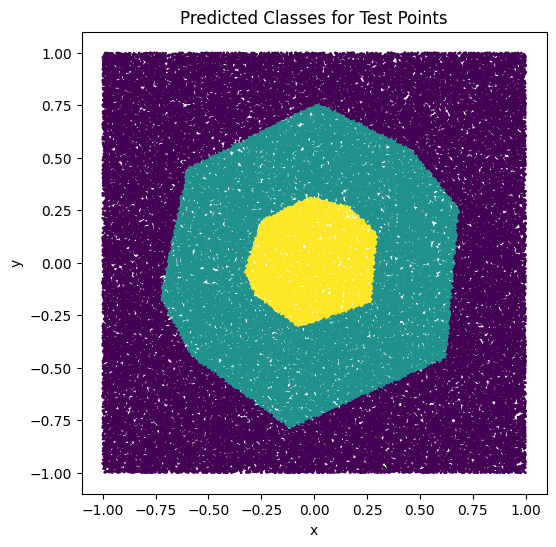

In [14]:
import numpy as np
import matplotlib.pyplot as plt

n_points_test = 100000
points_test = np.random.uniform(-1, 1, (n_points_test, 2))
points_test_torch = torch.from_numpy(points_test).float()

net.eval()
output_test = net(points_test_torch)

probabilities = torch.softmax(output_test, dim=1)
predictions = torch.argmax(probabilities, dim=1)
predictions_np = predictions.numpy()

plt.figure(figsize=(6, 6))
plt.scatter(points_test[:, 0], points_test[:, 1], c=predictions_np, cmap='viridis', s=1)
plt.title('Predicted Classes for Test Points')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
